In [1]:
# %matplotlib inline
%matplotlib notebook

try:
    from importlib import reload
except:
    pass

from __future__ import print_function ## Force python3-like printing

import os

from matplotlib import pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

import sfdmap

from astropy.table import Table,Column

In [2]:
import json
import pandas as pd
import numpy as np

import pycoco as pcc
import pyCoCo as pccsim

from astropy.cosmology import LambdaCDM
from scipy.interpolate import InterpolatedUnivariateSpline

import lsst_tools as lsstt
from lcsim.simlib import SIMLIBReader
from lcsim.lcsim import LCSim
from datetime import datetime

In [3]:
def get_mjdmax_BessellV(sn):
    v = sn.lcfit.spline["BessellV"]    
    mjd_spline = np.arange(np.nanmin(sn.phot.data["BessellV"]["MJD"]), 
                 np.nanmax(sn.phot.data["BessellV"]["MJD"]),
                 0.001)
    w = np.where(v(mjd_spline) == np.nanmax(v(mjd_spline)))

    mjdmax = mjd_spline[w]
    
    return mjdmax

In [4]:
# verbose = True
verbose = False
log = True
# log = False
# logall = False
if log:
    gentime = str(datetime.now())
    logvars = ["gentime",
               "logpath",
#                "field_index",
#                "field",
#                "CCD_index",
               "z_sim",
               "MW_EBV",
               "mag_offset",
               "host_EBV",
               "mjdmax",
               "subtype",
               "w",
               "snindex",
               "snname",
               "flux",
               "n",
               "n_sne",
               ]

## Initialise pyCoCo    
fltPath = b"/Users/berto/Code/CoCo/data/filters"
rootPath = b"/Users/berto/Code/CoCo"
# rootPath = b"/Users/berto/projects/stunt_CoCo"

coco = pccsim.pyCoCo(fltPath, rootPath)
lcs = LCSim()



In [5]:
z_max = 0.301
## This is faster than choose_z_volume_SFR -
## choose_z_volume_SFR is faster to generate large numbers
binsize = 0.01
z = np.arange(0.0, z_max, binsize)
z_dz = np.arange(0.0 + binsize, z_max + binsize, binsize)

cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

v_z = cosmo.comoving_volume(z)
v_z_dz = cosmo.comoving_volume(z_dz)

v_dz = v_z_dz - v_z

norm_v_dz = v_dz / np.nanmax(v_dz)

sfr_z = lsstt.sims.calculate_SFR(z)
sfr_norm = sfr_z / np.nanmax(sfr_z)

volumetric_rate = norm_v_dz * sfr_norm
normed_volumetric_rate = volumetric_rate / np.nanmax(volumetric_rate)
## Generate probability density function
pdf = InterpolatedUnivariateSpline(z, normed_volumetric_rate)

In [6]:
info = pcc.InfoClass()
info.load()

filter_names = ["SDSS_u","SDSS_g","SDSS_r","SDSS_i","SDSS_z"]

zp_dict = {}
for i in filter_names:
    zp_dict[i] = pcc.kcorr.calc_AB_zp(i)

n_sne = 0
n = 0

lc_outdir = "/Users/berto/projects/SDSS_sims/testing/z_evo/lcs/"
log_outdir = "/Users/berto/projects/SDSS_sims/testing/z_evo/logs/"

outfile = lc_outdir + "SN_"
logfile = log_outdir + "LOG_SN_"

In [7]:
mjd_list = np.arange(0.,101,1.0)-20
mjd_to_sim = np.array([])
filters_to_sim = []

for mjd in mjd_list:
    for filter_name in filter_names:
        filters_to_sim = np.append(filters_to_sim, lsstt.utils.b(filter_name))
        mjd_to_sim = np.append(mjd_to_sim, mjd)


In [8]:
# filters_to_sim
# mjd_to_sim
# len(mjd_to_sim)

In [9]:
verbose = True

## choose MWEBV
# MW_EBV = obslog.mwebv.mean()
MW_EBV = 0.05
if verbose: print(MW_EBV)

## Choose MagOffset
# mag_offset = np.random.choice(mag_offsets)
mag_offset = lsstt.sims.choose_magoffset(n=1)
if verbose: print("magoffset = ", mag_offset)

## Choose HostEBV
host_EBV = lsstt.sims.choose_extinction_host(n=1)
if verbose: print(MW_EBV)

## Choose MJDmax
# mjdmax = lsstt.sims.choose_MJDmax(obslog, n=1)
mjdmax = np.array([10])
if verbose: print(mjdmax)

## Choose SN Type
subtype = lsstt.sims.choose_subtype()
if verbose: print(subtype)

## Choose SN
w = np.where(info.table["Type"] == subtype)[0]
snindex = np.random.choice(w)
# snname = pcc.utils.b(info.table["snname"].data[w][0])
snname = pcc.utils.b("SN1994I")


if verbose: print(w, snname)

0.05
magoffset =  [-0.32115028]
0.05
[10]
IIb
[ 0  2 16 17 24 25 26] b'SN1994I'


In [10]:
z_sim = 0.001
z_sim = info.get_sn_info("SN1994I")["z_obs"]
print(z_sim)
z_sim = info.get_sn_info("SN1994I")["z_distmod"]
print(z_sim)

z_obs 
------
0.0015
   z_distmod    
----------------
0.00183405936245


In [11]:
flux, flux_err = coco.simulate(b"SN1994I",
                               0.001, 0.0, 0.0, 0.0, 3.1,
                               mjdmax, mjd_to_sim,
                               filters_to_sim)

In [12]:
print(mjdmax)
print(snname)

[10]
b'SN1994I'


/Users/berto/Code/CoCo/data/lc/SN1994I.dat
/Users/berto/Code/CoCo/data/lc/SN1994I.dat


<IPython.core.display.Javascript object>


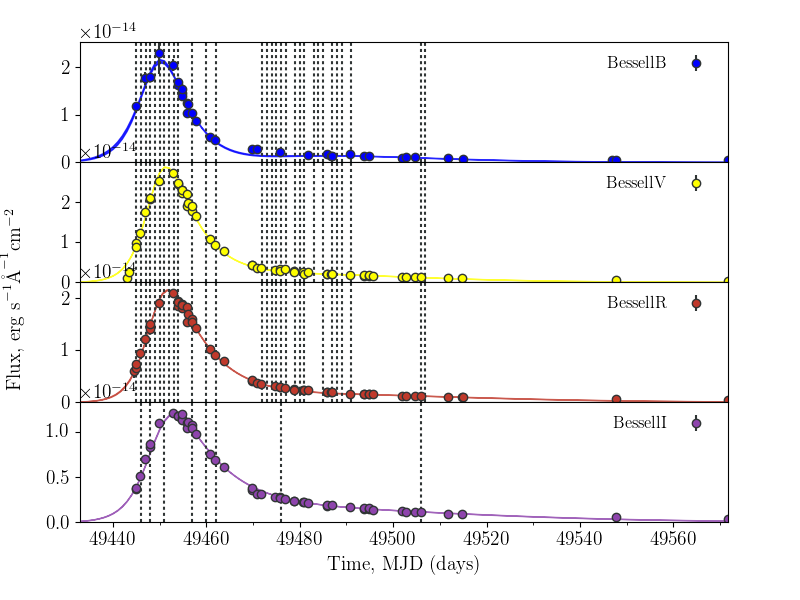

<IPython.core.display.Javascript object>


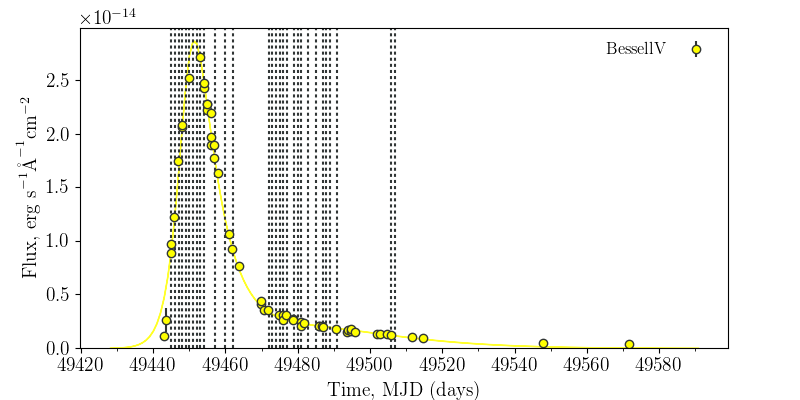

In [13]:
# snname = "SN2007uy"
snname = "SN1994I"
# snname = "SN1993J"


sn = pcc.SNClass(snname)

phot_path = os.path.join(pcc._default_data_dir_path, "lc/", snname + ".dat")
speclist_path = os.path.join(pcc._default_list_dir_path, snname + ".list")
recon_filename = os.path.join(pcc._default_recon_dir_path, snname + ".dat")

print(phot_path)
sn.load_phot(path = phot_path)
# sn.phot.plot()
sn.get_lcfit(recon_filename)

sn.load_list(path = speclist_path)
sn.load_spec()
# sn.load_mangledspec()
# sn.plot_spec()
# sn.plot_mangledspec()

# sn.plot_lc(multiplot = False, mark_spectra=True, savepng=True, outpath = "/Users/berto/projects/LSST/SN2007uy")
sn.plot_lc(multiplot = True, mark_spectra=True)
# sn.plot_lc(["BessellR"],multiplot = False, mark_spectra=True)
sn.plot_lc(["BessellV"],multiplot = False, mark_spectra=True)
# sn.plot_lc(multiplot = False, mark_spectra=True)

In [14]:
print(snname)
z_sim = 0.001
# z_sim = info.get_sn_info("SN1994I")["z_obs"]
z_sim = info.get_sn_info("SN1994I")["z_distmod"]
print(z_sim)

specphot_ap_table = Table()
# for filter_name in filter_names:
#     specphot = coco.spec_photometry(snname, 
#                      z_sim, lsstt.b(filter_name))
#     specphot_ap_table 
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("SDSS_g"))
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("SDSS_r"))
specphot = coco.spec_photometry(lsstt.b(snname), 
             z_sim, lsstt.b("BessellV"))
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("BessellR"))
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("BessellI"))
# specphot = coco.spec_photometry(lsstt.b(snname), 
#              z_sim, lsstt.b("SDSS_z"))

SN1994I
   z_distmod    
----------------
0.00183405936245


In [15]:
specphot

array([[  2.59111000e+01,   3.38892000e+01,   5.58263000e+01,
          2.29256000e+01,   2.98552000e+00,   3.18922000e+01,
          2.39141000e+01,  -2.00699000e+00,   2.49126000e+01,
          2.19271000e+01,   3.28907000e+01,  -9.98502000e-03,
          1.98702000e+00,   3.98702000e+01,   2.79081000e+01,
          3.78732000e+01,   5.97104000e+00,  -4.99251000e+00,
          3.58862000e+01,   2.09286000e+01,   1.09536000e+01,
          9.88517000e-01,  -3.00549000e+00,   2.99051000e+01,
         -3.99401000e+00,   8.96655000e+00,   2.89066000e+01,
          5.48278000e+01,   3.68847000e+01,  -1.00849000e+00,
         -5.99101000e+00],
       [  2.68666018e-15,   2.17660139e-15,   1.19726024e-15,
          3.06621021e-15,   2.54249319e-14,   2.27072399e-15,
          2.92144383e-15,   2.49853155e-14,   2.79507484e-15,
          3.24231068e-15,   0.00000000e+00,   2.92559048e-14,
          2.76098685e-14,   1.91487178e-15,   2.51542268e-15,
          2.00337576e-15,   1.79606740e-14,

<IPython.core.display.Javascript object>


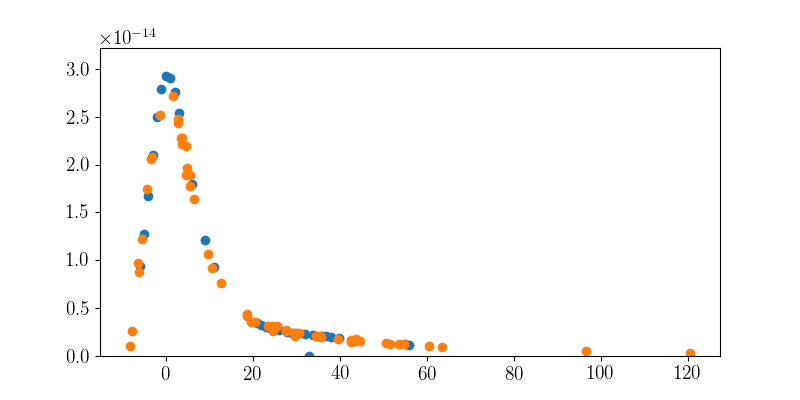

In [16]:
mjdpeak = get_mjdmax_BessellV(sn)

fig = plt.figure(figsize=[8, 4])
ax1 = fig.add_subplot(111)
ax1.scatter(specphot[0], specphot[1])
ax1.scatter(sn.phot.data["BessellV"]["MJD"]-mjdpeak, sn.phot.data["BessellV"]["flux"])
ax1.set_ylim(np.nanmin(specphot[1]), np.nanmax(specphot[1])*1.1)
plt.show()

In [ ]:
sn.plot_spec()

In [ ]:
sn.load_mangledspec()

In [ ]:
sn.plot_mangledspec()

In [ ]:
mangledspec_list = list(sn.mangledspec.keys())
spec_list = list(sn.spec.keys())

In [ ]:
for i, ms in enumerate(mangledspec_list):
    print(ms, spec_list[i], i)
    sn.mangledspec[ms].plot_comparison(sn.spec[spec_list[i]])

In [ ]:
verbose = False
stepsize = 0.05
plot = True

for z_sim in np.arange(0.001, z_max+stepsize,stepsize):
    print("simulating " , snname, "at z=", z_sim)
    if log:
        logpath = logfile + str(n_sne+1).rjust(6, "0") +".json"
#     snname = lsstt.b(snname)
    # snname = b"SN2011dh"
    # mag_offset = -2.0 ## Make Ia-like
    ## Simulate "Perfect" LC
    flux, flux_err = coco.simulate(snname,
                                   z_sim, mag_offset, MW_EBV, host_EBV, 3.1,
                                   mjdmax, mjd_to_sim,
                                   filters_to_sim)
    #
    # flux, flux_err = coco.simulate(snname,
    #                                z_obs, 0.0, 0.0, 0.0, 3.1,
    #                                mjdmax, mjd_to_sim,
    #                                filters_to_sim)
#         print(flux)
    p = pcc.PhotometryClass()
    p.load_table(pcc.utils.simulate_out_to_ap_table(mjd_to_sim, flux, flux_err, filters_to_sim), verbose=False)
    if plot: p.plot(enforce_zero=True)

    ## calculate zeropoints and convert to mag
    p_df = p.phot.to_pandas()
    p_df["zp"] = p_df["filter"].map(zp_dict)
    if verbose: print(p_df)
    p_df["mag"] = -2.5 * np.log10(p_df.flux) - p_df.zp

    ## Add noise - returns units of
#         flux, flux_err = lcs.simulate(p_df["mag"], obslog, unit="ab")
    flux = pd.Series(flux)
    flux_err = pd.Series(0.05*flux)

#     if plot:
#         plt.errorbar(p_df.MJD, flux, yerr=flux_err.values, fmt="o")
#         plt.show()

    w_detected = np.where((~np.isnan(flux.values)) & ((flux.values/flux_err.values) > 5))[0]
    # if verbose:
    if verbose:
        print("Flux, Flux_err")
        print(flux, flux_err)
    if verbose:
        print("where detected, len")
        print(w_detected, len(w_detected))


    if verbose: print("good sne")
    ## Remove redshift simulated at top of code from the list
    # z_obs = np.delete(z_obs, [w_z])

    p_df["flux"] = flux
    p_df["flux_err"] = flux_err
    p_df["#MJD"] = p_df["MJD"]
    p_df.fillna(0, inplace = True)
    full_out_path = outfile + str(z_sim).rjust(6, "0") + ".dat"
    p_df[["#MJD", "flux", "flux_err", "filter"]].to_csv(full_out_path, sep=" ", index = False, )

    if log:
        logdict = {}
        for i in logvars:
            if type(locals()[i]) == np.ndarray:
                logdict[i] = locals()[i].tolist()
            elif type(locals()[i]) == np.int64:
                logdict[i] = int(locals()[i])
            elif type(locals()[i]) == pd.Series:
                logdict[i] = locals()[i].to_json()
            elif type(locals()[i]) == bytes:
                logdict[i] = str(locals()[i], "utf-8")
            else:
                logdict[i] = locals()[i]

        with open(logpath, "w") as ofile:
            json.dumps(logdict, sort_keys=True,
                       indent=4, separators=(',', ': '))
            #     for i in logvars:
            json.dump(logdict, ofile, sort_keys=True,
                      indent=4, separators=(',', ': '))

        #         ofile.write(str(i) + " " + str(locals()[i]) + "\n")
            ofile.close()


In [ ]:
flux_err.values

In [ ]:
-2.5 * np.log10(p_df.flux) - p_df.zp

Load in an templates object 